# Verification experiments
_Author: Bart van Erp_ 

_Date:   31-01-2022_

This notebook contains the verification experiments to the paper **Model-Based Source Separation Using Invertible Neural Networks**.

## Load packages

In [1]:
using Revise
using SourceSeparationNF
using LinearAlgebra, Random
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
# generate data if it does not exist yet
t = 0:0.01:100
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/signal")
    mkdir("data/noise")
    mkdir("data/mix")

    # generate data and save
    for k = 1:5
        h5write(string("data/signal/", k, ".h5"), "signal", sin.(3*1*t))
        h5write(string("data/noise/",  k, ".h5"), "signal", cos.(7*1*t))
        h5write(string("data/mix/",    k, ".h5"), "signal", sin.(3*1*t) + cos.(7*1*t))
    end

end

In [3]:
# load data
data_signal = Data("data/signal/" .* readdir("data/signal"), Float64)
data_noise  = Data("data/noise/"  .* readdir("data/noise"),  Float64)
data_mix    = Data("data/mix/"    .* readdir("data/mix"),    Float64);

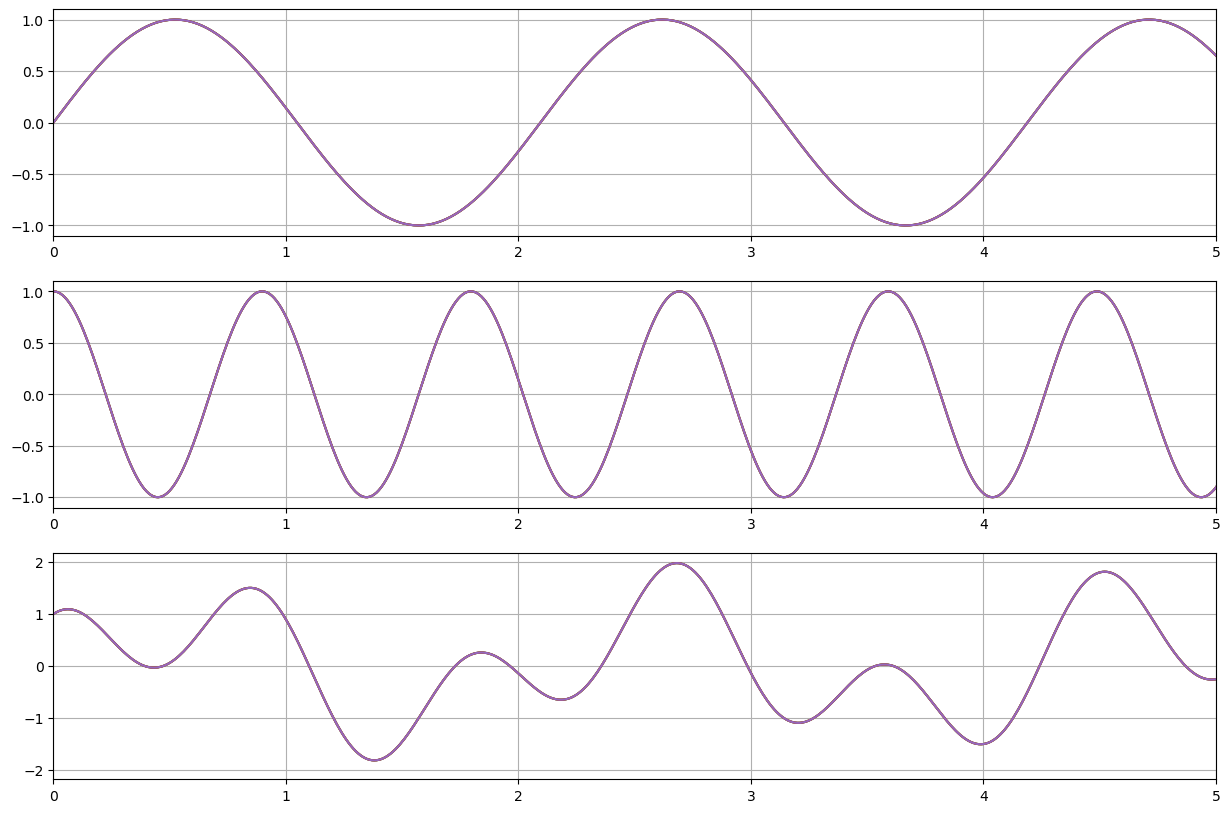

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [4]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(t, data_signal[k])
    ax[2].plot(t, data_noise[k])
    ax[3].plot(t, data_mix[k])
end
ax[1].set_xlim(0,5), ax[1].grid()
ax[2].set_xlim(0,5), ax[2].grid()
ax[3].set_xlim(0,5), ax[3].grid();

## Train models

In [5]:
function create_nar_model(dim; shift=1, optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (   
            NarLayer(dim,
                Model(dim-shift, shift,
                    (
                        DenseLayer(dim-shift, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, shift; optimizer=optimizer, batch_size=batch_size),
                    ); batch_size=batch_size
                ); batch_size=batch_size
            ),
        ); batch_size=batch_size
    )
end
batch_size = 16
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [6]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_nar_model(dim_in; batch_size=batch_size)

    # set learning rate
    setlr!(model_signal, 1e-4)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_signal,            # train data
        data_noise,             # test data
        100,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

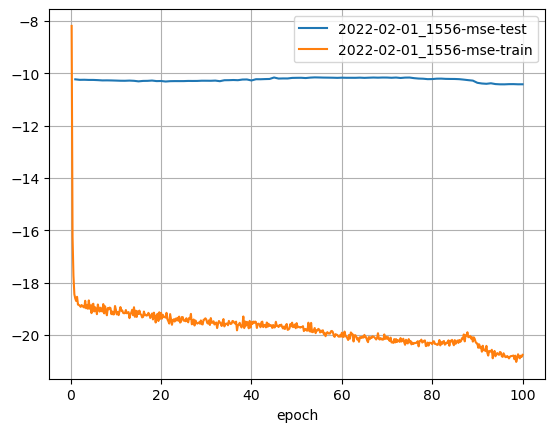

In [7]:
plot_logs(; path="logs/signal/", logscale=true);

In [8]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_nar_model(dim_in; batch_size=batch_size)

    # set learning rate
    setlr!(model_noise, 1e-4)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_noise,            # train data
        data_signal,           # test data
        100,                    # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

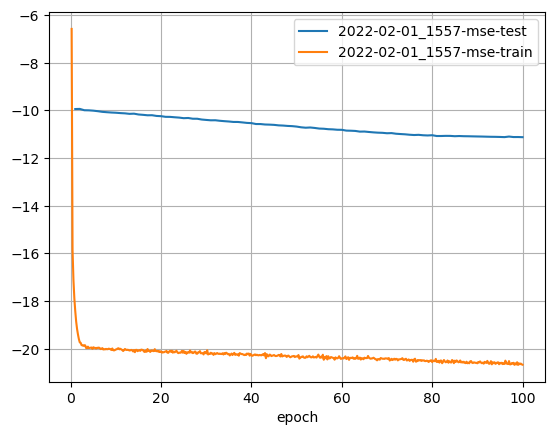

In [9]:
plot_logs(; path="logs/noise/", logscale=true);

## Kalman priors

In [87]:
H = zeros(2*dim_in)
H[1] = 1
H[1+batch_size] = 1
Q = zeros(2*dim_in, 2*dim_in)
R = 0# 1e-6# 1e-3
Q[1,1] = 2e-4 * dim_in
Q[1+dim_in, 1+dim_in] = 2e-4 * dim_in

signal_mix = data_mix[1]

m_x_prior = randn(2*dim_in)#vcat(data_signal[1][16:-1:1], data_noise[1][16:-1:1])#zeros(2*batch_size)
V_x_prior = 1e1*diagm(ones(2*dim_in));

## Extended Kalman filtering

In [88]:
mem_signal_m = zeros(length(signal_mix))
mem_signal_v = zeros(length(signal_mix))
mem_noise_m = zeros(length(signal_mix))
mem_noise_v = zeros(length(signal_mix));

In [89]:
# priors
m_x = copy(m_x_prior)
V_x = copy(V_x_prior)

for k in dim_in+1:length(signal_mix)
    
    # predict step
    m_x_new = vcat(forward(model_signal, m_x[1:dim_in]), forward(model_noise, m_x[dim_in+1:end]))
    F = vcat(hcat(jacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), jacobian(model_noise, m_x[dim_in+1:end])))
    V_x_new = F*V_x*F' + Q

    # update step
    y = signal_mix[k] - dot(H, m_x_new)
    S = dot(H, V_x_new, H) + R
    K = V_x_new * H * inv(S)
    m_x = m_x_new + K*y
    # V_x = V_x_new - K*S*K'
    V_x = (I - K*H')*V_x_new

    # save values
    mem_signal_m[k] = m_x[1]
    mem_signal_v[k] = V_x[1,1]
    mem_noise_m[k] = m_x[1+dim_in]
    mem_noise_v[k] = V_x[1+dim_in,1+dim_in]

end

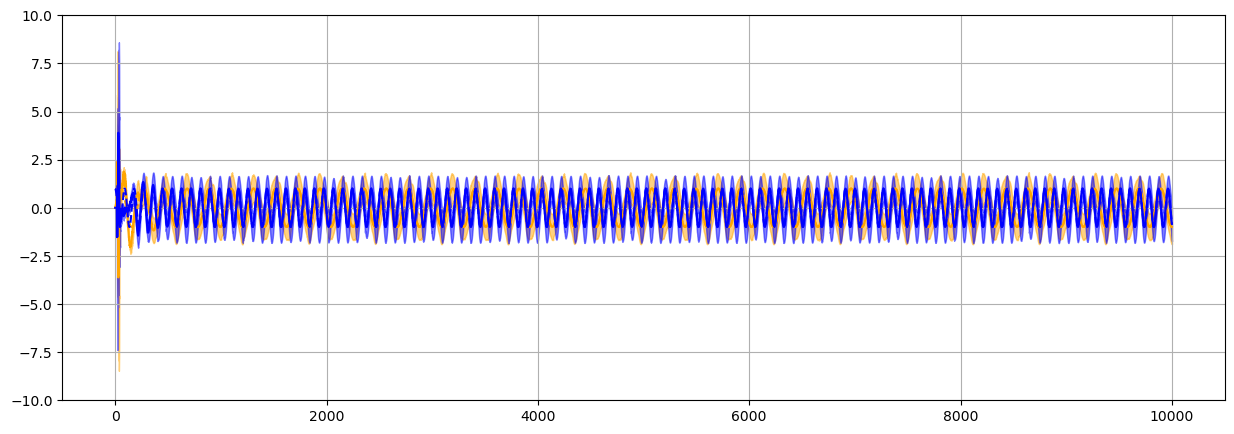

(-10.0, 10.0)

In [90]:
plt.figure(figsize=(15,5))
plt.fill_between(1:10001, mem_signal_m+sqrt.(mem_signal_v), mem_signal_m-sqrt.(mem_signal_v), color="orange", alpha=0.5)
plt.plot(mem_signal_m, color="orange")
plt.plot(data_signal[1], color="orange", linestyle="--")
plt.fill_between(1:10001, mem_noise_m+sqrt.(mem_noise_v), mem_noise_m-sqrt.(mem_noise_v), color="blue", alpha=0.5)
plt.plot(mem_noise_m, color="blue")
plt.plot(data_noise[1], color="blue", linestyle="--")
plt.grid()
plt.ylim(-10,10)

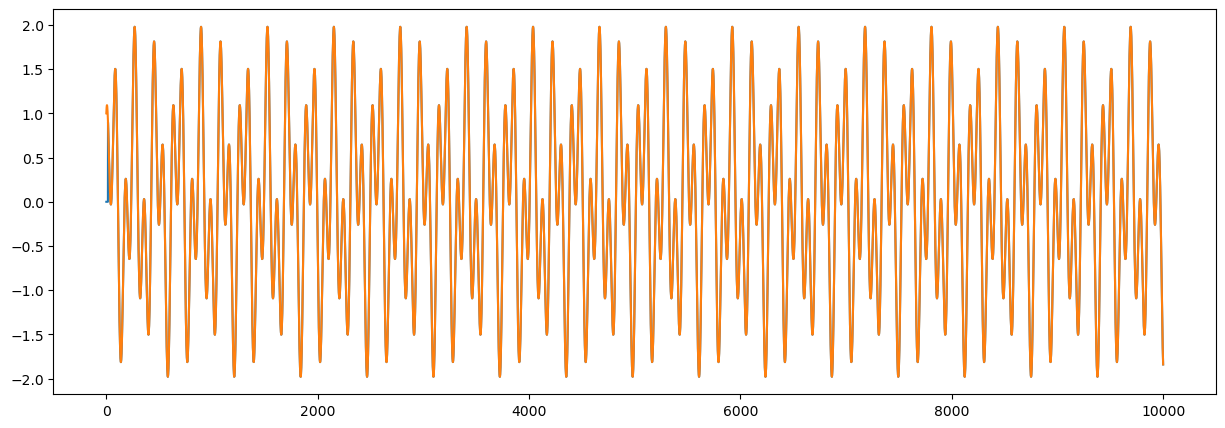

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000B228670>

In [91]:
plt.figure(figsize=(15,5))
plt.plot(mem_signal_m + mem_noise_m)
plt.plot(signal_mix)

## Extended Kalman smoothing

In [92]:
# priors
m_x = copy(m_x_prior)
V_x = copy(V_x_prior)
m_x_f = Vector{Vector{Float64}}(undef,length(signal_mix))
V_x_f = Vector{Matrix{Float64}}(undef,length(signal_mix))
m_x_s = Vector{Vector{Float64}}(undef,length(signal_mix))
V_x_s = Vector{Matrix{Float64}}(undef,length(signal_mix))

for k in dim_in+1:length(signal_mix)
    
    # predict step
    m_x_new = vcat(forward(model_signal, m_x[1:dim_in]), forward(model_noise, m_x[dim_in+1:end]))
    F = vcat(hcat(jacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), jacobian(model_noise, m_x[dim_in+1:end])))
    V_x_new = F*V_x*F' + Q

    # filtering messages
    y = signal_mix[k] - dot(H, m_x_new)
    S = dot(H, V_x_new, H) + R
    K = V_x_new * H * inv(S)
    m_x = m_x_new + K*y
    # V_x = V_x_new - K*S*K'
    V_x = (I - K*H')*V_x_new

    # save values
    m_x_f[k] = copy(m_x)
    V_x_f[k] = copy(V_x)

end

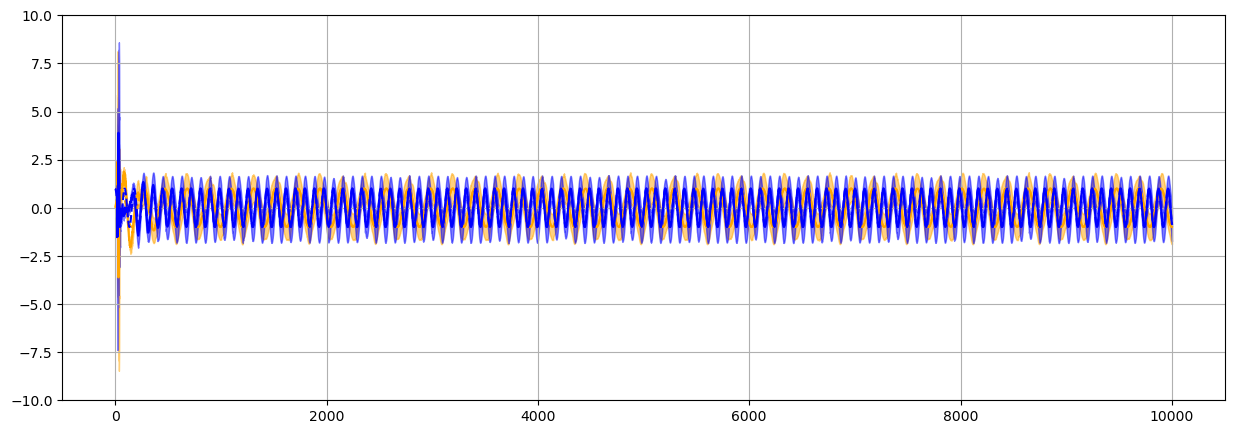

(-10.0, 10.0)

In [93]:
mem_signal_m = [m_x_f[k][1] for k = dim_in+1:length(signal_mix)]
mem_signal_v = [V_x_f[k][1,1] for k = dim_in+1:length(signal_mix)]
mem_noise_m = [m_x_f[k][1+dim_in] for k = dim_in+1:length(signal_mix)]
mem_noise_v = [V_x_f[k][1+dim_in,1+dim_in] for k = dim_in+1:length(signal_mix)]
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:10001, mem_signal_m+sqrt.(mem_signal_v), mem_signal_m-sqrt.(mem_signal_v), color="orange", alpha=0.5)
plt.plot(dim_in+1:10001, mem_signal_m, color="orange")
plt.plot(data_signal[1], color="orange", linestyle="--")
plt.fill_between(dim_in+1:10001, mem_noise_m+sqrt.(mem_noise_v), mem_noise_m-sqrt.(mem_noise_v), color="blue", alpha=0.5)
plt.plot(dim_in+1:10001, mem_noise_m, color="blue")
plt.plot(data_noise[1], color="blue", linestyle="--")
plt.grid()
plt.ylim(-10,10)

In [94]:
m_x_new = zeros(2*dim_in)
V_x_new = diagm(1e5*ones(2*dim_in))

m_x_s[end] = copy(m_x_new)
V_x_s[end] = copy(V_x_new)

for k in length(signal_mix)-1:-1:1+dim_in

    # pass through equality node (and H)
    G = inv(R + dot(H, V_x_new, H))
    m_x = m_x_new + V_x_new*H*G*(signal_mix[k+1] - dot(H, m_x_new)) # to check
    V_x = V_x_new - V_x_new * H * G* H'* V_x_new
    
    # pass through non-linear node
    m_x_new = vcat(backward(model_signal, m_x[1:dim_in]), backward(model_noise, m_x[dim_in+1:end]))
    F = vcat(hcat(invjacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), invjacobian(model_noise, m_x[dim_in+1:end])))
    V_x_new = F*V_x*F' + Q    

    # save values
    m_x_s[k] = copy(m_x_new)
    V_x_s[k] = copy(V_x_new)

end

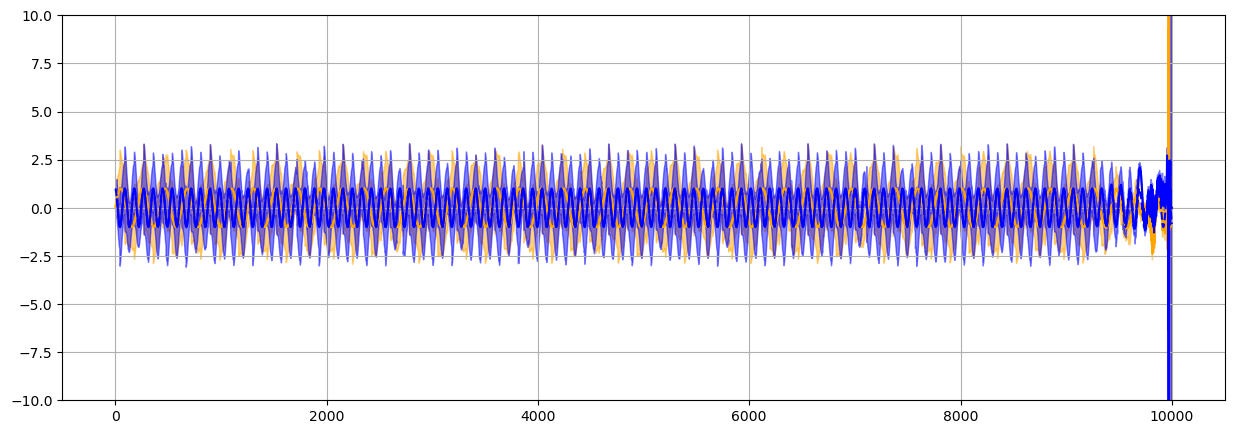

(-10.0, 10.0)

In [95]:
mem_signal_m = [m_x_s[k][1] for k = dim_in+1:length(signal_mix)]
mem_signal_v = [V_x_s[k][1,1] for k = dim_in+1:length(signal_mix)]
mem_noise_m = [m_x_s[k][1+dim_in] for k = dim_in+1:length(signal_mix)]
mem_noise_v = [V_x_s[k][1+dim_in,1+dim_in] for k = dim_in+1:length(signal_mix)]
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:10001, mem_signal_m+sqrt.(mem_signal_v), mem_signal_m-sqrt.(mem_signal_v), color="orange", alpha=0.5)
plt.plot(dim_in+1:10001, mem_signal_m, color="orange")
plt.plot(data_signal[1], color="orange", linestyle="--")
plt.fill_between(dim_in+1:10001, mem_noise_m+sqrt.(mem_noise_v), mem_noise_m-sqrt.(mem_noise_v), color="blue", alpha=0.5)
plt.plot(dim_in+1:10001, mem_noise_m, color="blue")
plt.plot(data_noise[1], color="blue", linestyle="--")
plt.grid()
plt.ylim(-10,10)
# plt.xlim(9000,10000)

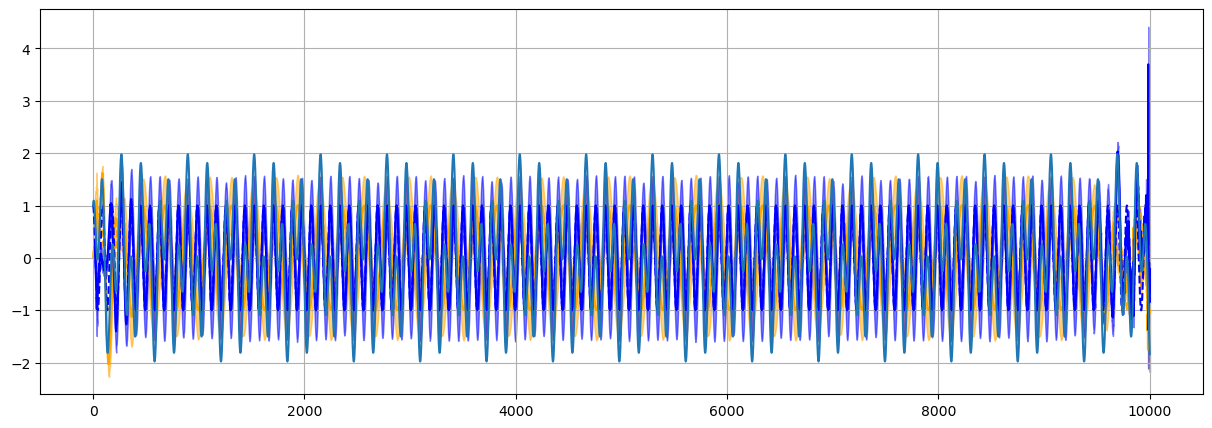

In [96]:
mem_signal_m = [m_x_s[k][1] for k = dim_in+1:length(signal_mix)]
mem_signal_v = [V_x_s[k][1,1] for k = dim_in+1:length(signal_mix)]
mem_noise_m = [m_x_s[k][1+dim_in] for k = dim_in+1:length(signal_mix)]
mem_noise_v = [V_x_s[k][1+dim_in,1+dim_in] for k = dim_in+1:length(signal_mix)]

marg_x_v = [cholinv(cholinv(V_x_s[k])+cholinv(V_x_f[k])) for k = dim_in+1:length(signal_mix)]
marg_x_m = [marg_x_v[k-dim_in] * (cholinv(V_x_s[k])*m_x_s[k] + cholinv(V_x_f[k])*m_x_f[k]) for k = dim_in+1:length(signal_mix)]

mem_marg_signal_v = [marg_x_v[k][1,1] for k = 1:length(signal_mix)-dim_in]
mem_marg_signal_m = [marg_x_m[k][1] for k = 1:length(signal_mix)-dim_in]
mem_marg_noise_v = [marg_x_v[k][1+dim_in,1+dim_in] for k = 1:length(signal_mix)-dim_in]
mem_marg_noise_m = [marg_x_m[k][1+dim_in] for k = 1:length(signal_mix)-dim_in]

plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:10001, mem_marg_signal_m+sqrt.(mem_marg_signal_v), mem_marg_signal_m-sqrt.(mem_marg_signal_v), color="orange", alpha=0.5)
plt.plot(dim_in+1:10001, mem_marg_signal_m, color="orange")
plt.plot(data_signal[1], color="orange", linestyle="--")
plt.fill_between(dim_in+1:10001, mem_marg_noise_m+sqrt.(mem_marg_noise_v), mem_marg_noise_m-sqrt.(mem_marg_noise_v), color="blue", alpha=0.5)
plt.plot(dim_in+1:10001, mem_marg_noise_m, color="blue")
plt.plot(data_noise[1], color="blue", linestyle="--")
plt.plot(signal_mix)
plt.grid()
